<a href="https://colab.research.google.com/github/tabaraei/depression-detection/blob/master/depression_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Old

## Main code

Source code: [Github](https://github.com/speechandlanguageprocessing/ICASSP2022-Depression/blob/main/DepressionCollected/Classification/audio_features_whole.py)

In [ ]:
import os
import wave
import numpy as np
import librosa
import tensorflow as tf


DATA_DIR = '/content/drive/MyDrive/Data/DepressionDetection/EATD-Corpus'
X_train, y_train = list(), list()
X_test, y_test = list(), list()

def load_wave(data_path):
    data_file = wave.open(data_path)
    sr = data_file.getframerate()
    nframes = data_file.getnframes()
    wave_data = np.frombuffer(data_file.readframes(nframes), dtype=np.short).astype(float)
    length = nframes / sr
    return data_file, wave_data, length, nframes, sr

def wav2mel(wave_data, sr):
    cluster_size = 16
    signal = wave_data
    melspec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=80).astype(np.float32).T
    melspec = np.log(np.maximum(1e-6, melspec))
    return melspec

for sample in os.listdir(DATA_DIR):
    positive_file, wave_data1, len1, nframes1, sr1 = load_wave(f'{DATA_DIR}/{sample}/positive_out.wav')
    neutral_file, wave_data2, len2, nframes2, sr2 = load_wave(f'{DATA_DIR}/{sample}/neutral_out.wav')
    negative_file, wave_data3, len3, nframes3, sr3 = load_wave(f'{DATA_DIR}/{sample}/negative_out.wav')

    with open(f'{DATA_DIR}/{sample}/new_label.txt') as label:
        target = float(label.readline())

    if wave_data1.shape[0] < 1:
        wave_data1 = np.array([1e-4]*sr1*5)
    if wave_data2.shape[0] < 1:
        wave_data2 = np.array([1e-4]*sr2*5)
    if wave_data3.shape[0] < 1:
        wave_data3 = np.array([1e-4]*sr3*5)

    audio_features = [
        wav2mel(wave_data1, sr1),
        wav2mel(wave_data2, sr2),
        wav2mel(wave_data3, sr3)
    ]
    # targets.append(1 if target >= 53 else 0)

    if sample.startswith('t'):
        # Training Data
        X_train.append(audio_features)
        y_train.append(target)
    else:
        # Test Data
        X_test.append(audio_features)
        y_test.append(target)
    break

print(X_test[0][0].shape)
print(X_test[0][1].shape)
print(X_test[0][2].shape)

(1068, 80)
(1201, 80)
(930, 80)


## Waveform

In [ ]:
import torch
import torchaudio

DATA_DIR = '/content/drive/MyDrive/Data/DepressionDetection/EATD-Corpus'
AUDIO_FILE = f'{DATA_DIR}/t_1/positive_out.wav'

positive_file, wave_data1, len1, nframes1, sr1 = load_wave(AUDIO_FILE)
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

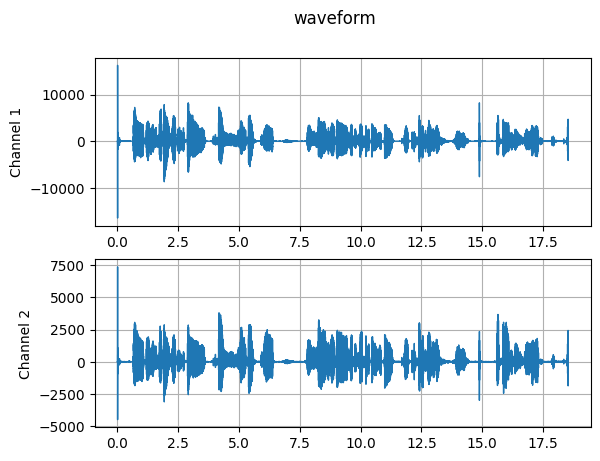

In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

plot_waveform(waveform, sample_rate)

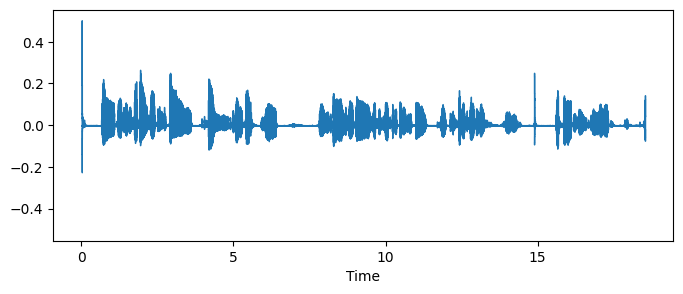

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
_ = librosa.display.waveshow(wave_data1, sr=sr1)

## Spectrogram

Some codes taken from [here](https://pytorch.org/audio/0.11.0/tutorials/audio_feature_extractions_tutorial.html#melspectrogram)

In [ ]:
import torchaudio.transforms as T

mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate, n_mels=80)
melspec = mel_spectrogram(waveform)

In [ ]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

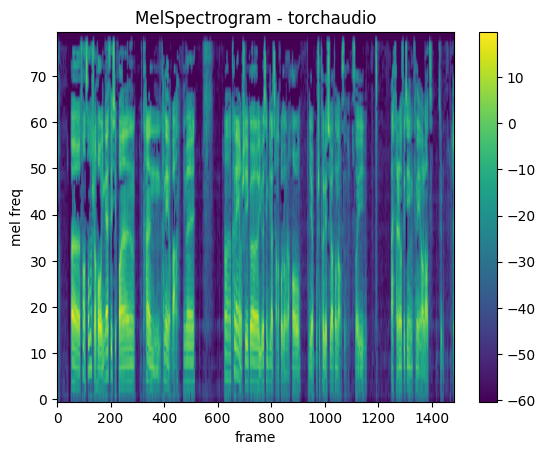

In [ ]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [ ]:
melspec_librosa = librosa.feature.melspectrogram(
    y=waveform.numpy()[0],
    sr=sample_rate,
    n_mels=80
)

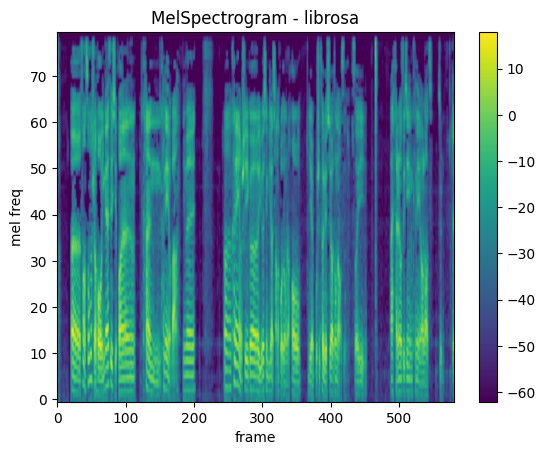

In [ ]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

# Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange


class EATDCorpusDataset(Dataset):
    def __init__(self):
        self.DATA_DIR = '/content/drive/MyDrive/Data/DepressionDetection/EATD-Corpus'
        self.X_train = list()
        self.y_train = list()
        self.X_test = list()
        self.y_test = list()
        self.train = bool()
        self.n_samples_train = 0
        self.n_samples_test = 0
        self.MAX_LENGTH = -1
        self.load_dataset()

    def __getitem__(self, index):
        if self.train:
            return self.X_train[index], self.y_train[index]
        else:
            return self.X_test[index], self.y_test[index]

    def __len__(self):
        if self.train:
            return self.n_samples_train
        else:
            return self.n_samples_test

    def extract_features(self, path):
        try:
            waveform, sr = torchaudio.load(path)
            mel_spectrogram = transforms.MelSpectrogram(sample_rate=sr, n_mels=80)
            melspec = mel_spectrogram(waveform)
            return melspec
        except:
            return torch.tensor([])

    def load_wav(self, sample):
        # Load the audio files and extract the MelSpec features
        melspec1 = self.extract_features(f'{self.DATA_DIR}/{sample}/positive_out.wav')
        melspec2 = self.extract_features(f'{self.DATA_DIR}/{sample}/neutral_out.wav')
        melspec3 = self.extract_features(f'{self.DATA_DIR}/{sample}/negative_out.wav')
        features = torch.cat([t for t in [melspec1, melspec2, melspec3] if t.numel() > 0], dim=-1)

        # Load the labels
        with open(f'{self.DATA_DIR}/{sample}/new_label.txt') as label:
            target = float(label.readline())
            target = 1 if target >= 53 else 0

        # compute the max-length audio
        if features.shape[-1] > self.MAX_LENGTH:
            self.MAX_LENGTH = features.shape[-1]

        return features, target

    def add_padding(self, X):
        padded_tensors = list()
        for x in X:
            pad_size = self.MAX_LENGTH - x.shape[-1]
            padded_tensors.append(F.pad(x, (0, pad_size)))
        return torch.stack(padded_tensors)

    def load_dataset(self):
        for sample in tqdm(os.listdir(self.DATA_DIR)):
            features, target = self.load_wav(sample)
            if sample.startswith('t'):
                # Training data
                self.X_train.append(features)
                self.y_train.append(target)
                self.n_samples_train += 1
            else:
                # Test data
                self.X_test.append(features)
                self.y_test.append(target)
                self.n_samples_test += 1

        # Add padding and convert to tensors
        self.X_train = self.add_padding(self.X_train)
        self.X_test = self.add_padding(self.X_test)
        self.y_train = torch.tensor(self.y_train)
        self.y_test = torch.tensor(self.y_test)

In [3]:
import pickle


DATASET_DIR = '/content/drive/MyDrive/Data/DepressionDetection/EATD-Corpus-Preprocessed'
try:
    with open(f'{DATASET_DIR}/dataset.pkl', 'rb') as f:
        dataset = pickle.load(f)
except:
    dataset = EATDCorpusDataset()
    with open(f'{DATASET_DIR}/dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)

dataset.train = True
dataset.X_train.shape

torch.Size([83, 2, 80, 23748])

# Data Preview

In [ ]:
from IPython.display import Audio

AUDIO_FILE = f'{dataset.DATA_DIR}/t_1/positive_out.wav'
metadata = torchaudio.info(AUDIO_FILE)
print(metadata)

Audio(AUDIO_FILE)

AudioMetaData(sample_rate=16000, num_frames=296576, num_channels=2, bits_per_sample=16, encoding=PCM_S)


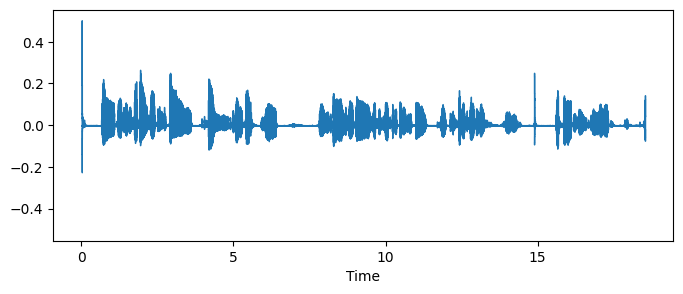

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

waveform, sample_rate = torchaudio.load(AUDIO_FILE)
plt.figure(figsize=(8, 3))
_ = librosa.display.waveshow(waveform.numpy(), sr=sample_rate)

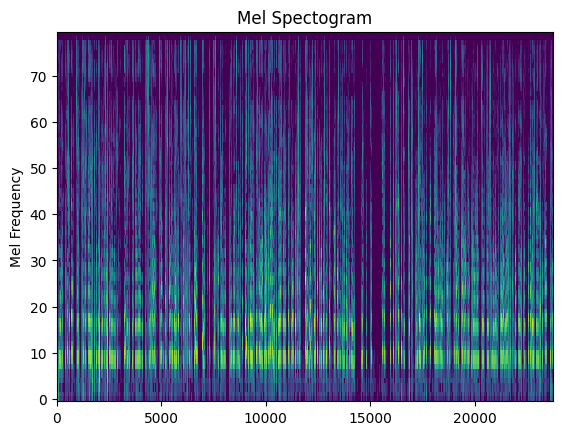

In [ ]:
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(spectrogram):
    plt.imshow(librosa.power_to_db(spectrogram), origin="lower", aspect="auto", interpolation="nearest")
    plt.title('Mel Spectogram')
    plt.ylabel('Mel Frequency')

# Data Preview
sample_idx = 7
channel = 0
plot_spectrogram(dataset.X_train[sample_idx, channel])

# Training

In [4]:
# Hyper-parameters
num_epochs = 5
learning_rate = 0.001
batch_size = 4

# Prepare training data loader
dataset.train = True
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# First batch dimensions
X_sample, y_sample = next(iter(train_loader))
X_sample.shape, y_sample.shape

(torch.Size([4, 2, 80, 23748]), torch.Size([4]))

In [5]:
class ConvNet(nn.Module):
    def __init__(self, input_height, input_width):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = lambda x: torch.flatten(x, start_dim=1)
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        # self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(16 * input_height * input_width, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        print(x.shape)
        # x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.sigmoid(self.fc2(x))
        print(x.shape)
        return x

# Model, Loss, and Optimizer
height = dataset.X_train.shape[-2]
width = dataset.X_train.shape[-1]
model = ConvNet(input_height=height, input_width=width).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Training

len(train_loader)
for i in trange(num_epochs):
    for inputs, labels in train_loader:
        # Computations on GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        # print(outputs.shape)
        # print(outputs)
        # loss = criterion(outputs, labels)

        # Backward pass and optimizer
        break
    break

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([4, 2, 80, 23748])
torch.Size([4, 6, 39, 11873])
torch.Size([4, 16, 18, 5935])
torch.Size([4, 1709280])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x1709280 and 30397440x64)

In [9]:
16 * height * width

30397440

# Test

In [ ]:
dataset.train = False
test_loader = DataLoader(dataset=dataset, batch_size=5, shuffle=True, num_workers=2)

# CNN

In [ ]:
# Training the model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Testing the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

100%|██████████| 170498071/170498071 [00:02<00:00, 56997282.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1,  2000] loss: 2.111
[1,  4000] loss: 1.692
[1,  6000] loss: 1.494
[1,  8000] loss: 1.380
[1, 10000] loss: 1.318
[1, 12000] loss: 1.228
[2,  2000] loss: 1.105
[2,  4000] loss: 1.048
[2,  6000] loss: 1.006
[2,  8000] loss: 0.959
[2, 10000] loss: 0.945
[2, 12000] loss: 0.907
Finished Training
Accuracy of the network on the 10000 test images: 68 %


In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
# PATH = './cnn.pth'
# torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')